In [3]:
import time
import mujoco
import numpy as np
from bayes_opt import BayesianOptimization
from FeedforwardBackflip import FeedforwardBackflip
from scipy.spatial.transform import Rotation
import mediapy as media


In [4]:
def compute_final_error(data):
    return np.array([data.qpos[0], data.qpos[2]-1, 0.2 * data.qvel[0], 0.2 * data.qvel[2],
                    Rotation.from_quat(np.roll(data.qpos[3:7], -1)).as_euler('xyz')[1]])


def simulate(params):  #(U1, T1, T3, U5, T5):
    # params = (U1, T1, T3, U5, T5)
    F, tau = flip.compute_control_sequence(params)
    episode_length = F.shape[0]
    data.qpos = np.array([0, 0, 1, 1, 0, 0, 0])
    data.qvel = np.zeros(6)
    for i in range(episode_length):
        data.ctrl = np.array([F[i], 0, tau[i], 0])
        for _ in range(int(control_step / simulation_step)):
            mujoco.mj_step(model, data, 1)
    final_error = compute_final_error(data)
    return np.linalg.norm(final_error)


def test(params):
    graphics_step = 0.02
    import glfw
    from util import sync
    from logger import Logger

    # initialize the library
    if not glfw.init():
        return

    # create a windowed mode window and its OpenGL context
    window = glfw.create_window(1280, 720, "Crazyflie in MuJoCo", None, None)
    if not window:
        glfw.terminate()
        return

    # make the window's context current
    glfw.make_context_current(window)

    # initialize visualization data structures
    cam = mujoco.MjvCamera()
    cam.azimuth, cam.elevation = 170, -30
    cam.lookat, cam.distance = [0, 0, 1], 2

    pert = mujoco.MjvPerturb()
    opt = mujoco.MjvOption()
    scn = mujoco.MjvScene(model, maxgeom=30)
    con = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_100)
    F, tau = flip.compute_control_sequence(params)
    episode_length = F.shape[0]
    logger = Logger(episode_length*control_step, control_step)
    start = time.time()
    frames = []
    frame_rate = 0

    with mujoco.Renderer(model, height=480, width=640) as renderer:
        for i in range(episode_length):
            simtime = data.time
            data.ctrl = np.array([F[i], 0, tau[i], 0])
            for _ in range(int(control_step / simulation_step)):
                mujoco.mj_step(model, data, 1)
                renderer.update_scene(data, camera='track')
                pixels = renderer.render()
                frames.append(pixels)
                frame_rate = int(1/(data.time - simtime))

            state = np.hstack([data.qpos[0:3], data.qvel[0:3],
                            Rotation.from_quat((np.roll(data.qpos[3:7], -1))).as_euler('xyz'), data.qvel[3:6],
                            np.zeros(14)])
            logger.log(timestamp=simtime, state=state, control=data.ctrl)
            
    final_error = compute_final_error(data)
    print(final_error)
    print(np.linalg.norm(final_error))
    logger.plot_ff()

    return frames, frame_rate



[-0.08213458 -0.49781655 -0.39913871 -0.71411901 -1.56505539]
1.8366391749344402


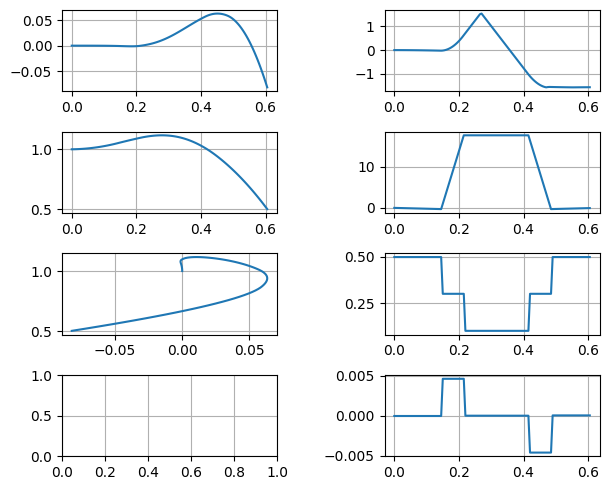

In [5]:
if __name__ == '__main__':
    model = mujoco.MjModel.from_xml_path("cf2_antal.xml")
    data = mujoco.MjData(model)
    flip = FeedforwardBackflip(model, data)
    control_step = 0.005
    simulation_step = 0.005

    frames, frame_rate = test([17.8, 0.15, 0.2, 17.8, 0.12])
    media.write_video("backflip_optimization.mp4", frames, fps=frame_rate)
    media.show_video(frames, fps=frame_rate)